<a href="https://colab.research.google.com/github/syma-afsha/Complete_Reinforcement_Learning/blob/main/Upper_Confidence_Bound_Action_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The problem is that ϵ-greedy explores randomly. It does not consider whether an unexplored action might have a higher reward or more uncertainty. **This wastes exploration on actions that are clearly suboptimal**.

**UCB solves this by adding an uncertainty bonus to each action.**

The algorithm has balanced exploration and exploitation.
- Higher selection counts reduce exploration for an arm.
- Dominance depends on the combination of 𝑄𝑡(𝑎) and exploration.



Comparison between Epsilion greedy Strategy vs Upper Confidence Bound Action Selection:

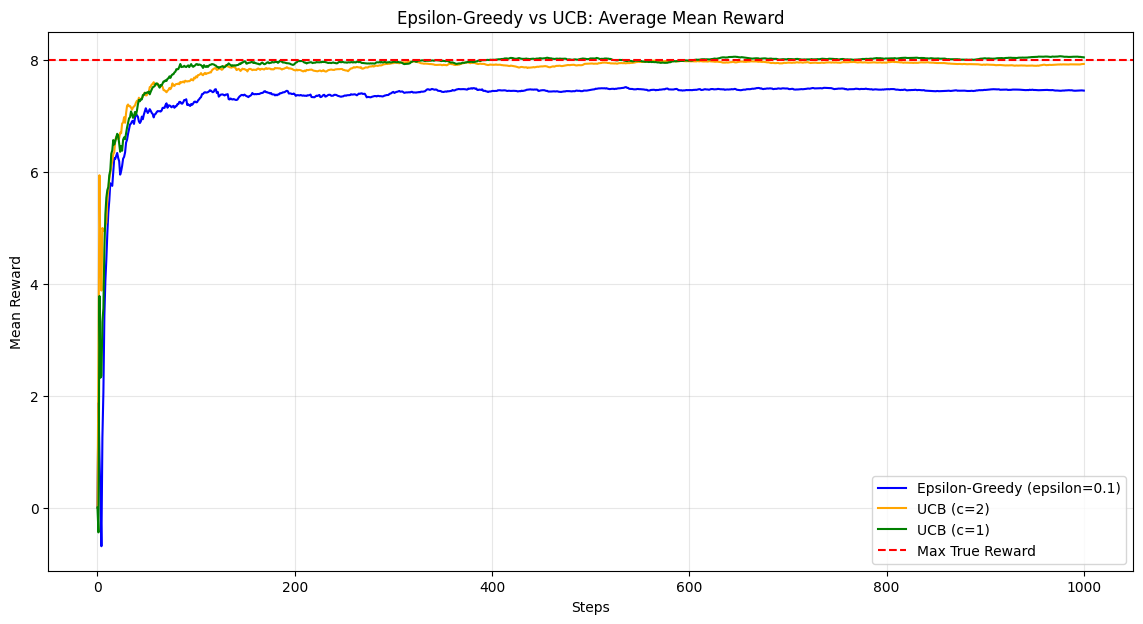

In [69]:
import numpy as np
import matplotlib.pyplot as plt

class BanditProblem:
    def __init__(self, trueActionValue, totalSteps, epsilion=None, c=None, strategy="epsilon-greedy"):
        # Initialize parameters
        self.trueActionValue = trueActionValue
        self.totalSteps = totalSteps
        self.currentStep = 0
        self.armnumber = np.size(trueActionValue)
        self.epsilion = epsilion  # Exploration probability for epsilon-greedy
        self.c = c  # Confidence parameter for UCB (c controls the level of exploration.)
        self.strategy = strategy  # Action selection strategy: "epsilon-greedy" or "ucb"

        # Tracking variables
        self.howManyTimeParticularArmIsSelected = np.zeros(self.armnumber)
        self.armMeanRewards = np.zeros(self.armnumber)
        self.currentReward = 0
        self.meanReward = np.zeros(totalSteps + 1)
        self.armMeanRewardsHistory = np.zeros((self.armnumber, totalSteps + 1))

    def SelectAction(self):
        if self.strategy == "epsilon-greedy":
            # Epsilon-greedy action selection
            probability = np.random.rand()
            if probability <= self.epsilion:
                selectArmIndex = np.random.choice(self.armnumber)  # Explore
            else:
                selectArmIndex = np.argmax(self.armMeanRewards)  # Exploit

        elif self.strategy == "ucb":
            # Upper Confidence Bound (UCB) action selection
            if np.any(self.howManyTimeParticularArmIsSelected == 0):
                # Ensure each arm is tried once
                selectArmIndex = np.argmax(self.howManyTimeParticularArmIsSelected == 0)
            else:
                #Select an action
                #balances the exploarationa nd exploitation
                ucb_values = self.armMeanRewards + self.c * np.sqrt(
                    np.log(self.currentStep + 1) / self.howManyTimeParticularArmIsSelected
                )
                selectArmIndex = np.argmax(ucb_values)

        else:
            raise ValueError("Invalid strategy. Choose 'epsilon-greedy' or 'ucb'.")

        # Update current step and arm selection count
        self.currentStep += 1
        self.howManyTimeParticularArmIsSelected[selectArmIndex] += 1

        # Simulate reward
        self.currentReward = np.random.normal(self.trueActionValue[selectArmIndex], 2)

        # Update arm mean rewards
        self.armMeanRewards[selectArmIndex] += (
            1 / self.howManyTimeParticularArmIsSelected[selectArmIndex]
        ) * (self.currentReward - self.armMeanRewards[selectArmIndex])

        # Update mean reward progression
        self.meanReward[self.currentStep] = self.meanReward[self.currentStep - 1] + (
            1 / self.currentStep
        ) * (self.currentReward - self.meanReward[self.currentStep - 1])

        # Track arm-specific mean reward progression
        for arm in range(self.armnumber):
            self.armMeanRewardsHistory[arm, self.currentStep] = self.armMeanRewards[arm]

    def playTime(self):
        # Simulate the bandit problem
        for _ in range(self.totalSteps):
            self.SelectAction()

    def clearAll(self):
        # Reset variables to original state
        self.currentStep = 0
        self.howManyTimeParticularArmIsSelected = np.zeros(self.armnumber)
        self.armMeanRewards = np.zeros(self.armnumber)
        self.currentReward = 0
        self.meanReward = np.zeros(self.totalSteps + 1)
        self.armMeanRewardsHistory = np.zeros((self.armnumber, self.totalSteps + 1))

# Testing
trueActionValue = [1.0, 8.0, -1.0, 5.0, 7.0]  # True mean rewards for each arm
totalSteps = 1000

# Epsilon-greedy
epsilon = 0.1
bandit_epsilon = BanditProblem(trueActionValue, totalSteps, epsilion=epsilon, strategy="epsilon-greedy")
bandit_epsilon.playTime()

# UCB
c = 2
bandit_ucb = BanditProblem(trueActionValue, totalSteps, c=c, strategy="ucb")
bandit_ucb.playTime()
c1 = 1
bandit_ucb_c = BanditProblem(trueActionValue, totalSteps, c=c1, strategy="ucb")
bandit_ucb_c.playTime()
# Plot results
plt.figure(figsize=(14, 7))
# Plot average mean rewards for both strategies
plt.plot(bandit_epsilon.meanReward, label="Epsilon-Greedy (epsilon=0.1)", color="blue")
plt.plot(bandit_ucb.meanReward, label="UCB (c=2)", color="orange")
plt.plot(bandit_ucb_c.meanReward, label="UCB (c=1)", color="green")
plt.axhline(np.max(trueActionValue), color="red", linestyle="--", label="Max True Reward")
plt.xlabel("Steps")
plt.ylabel("Mean Reward")
plt.title("Epsilon-Greedy vs UCB: Average Mean Reward")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




**UCB explores more initially, leading to slightly lower rewards early on, but quickly balances exploration and exploitation.
Epsilon-greedy converges faster early but explores less adaptively, leading to slightly lower long-term performance.
UCB performs better overall, approaching the optimal reward line more efficiently.**

**Lower (c=1) performs best in identifying the optimal arm quickly, making it ideal for shorter time horizons.
Higher (c=2)  offers a more stable performance but may require slightly more time to identify the best arm compared to c=2.**

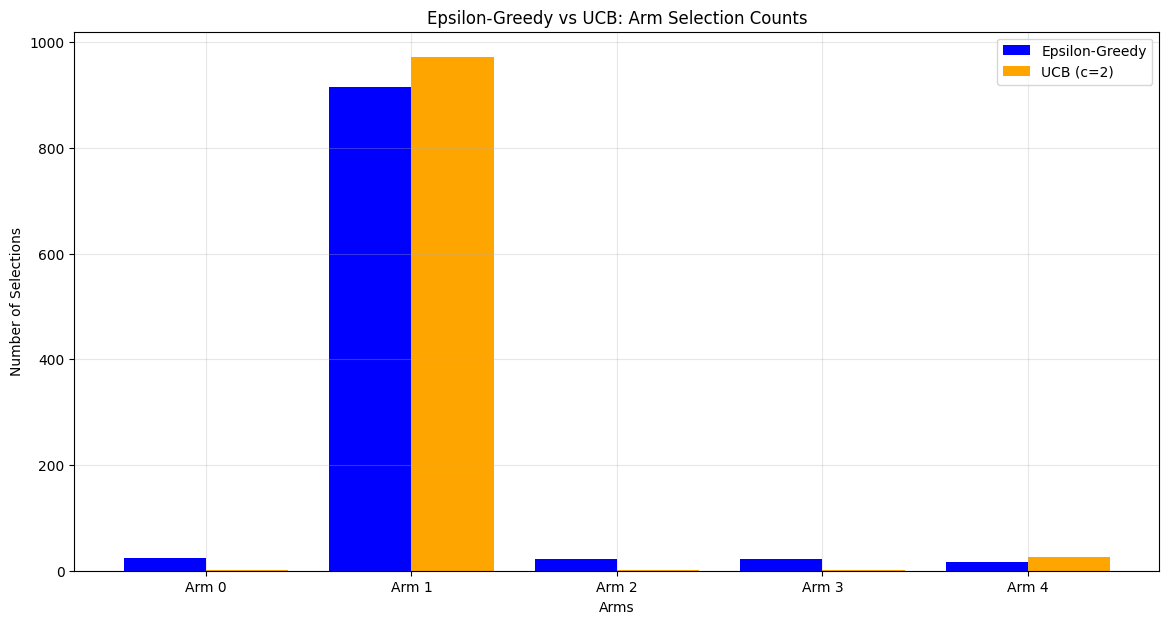

In [71]:
# Plot action counts for both strategies
plt.figure(figsize=(14, 7))

x = np.arange(len(trueActionValue))
plt.bar(x - 0.2, bandit_epsilon.howManyTimeParticularArmIsSelected, width=0.4, label="Epsilon-Greedy", color="blue")
plt.bar(x + 0.2, bandit_ucb.howManyTimeParticularArmIsSelected, width=0.4, label="UCB (c=2)", color="orange")

plt.xticks(x, [f"Arm {i}" for i in range(len(trueActionValue))])
plt.xlabel("Arms")
plt.ylabel("Number of Selections")
plt.title("Epsilon-Greedy vs UCB: Arm Selection Counts")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Epsilon-greedy selects non-dominant arms (like Arm 0, Arm 3, and Arm 4) slightly more often due to random exploration (𝜖=0.1).**
UCB explores less for these arms, as it relies on confidence intervals, avoiding unnecessary exploration of arms with clearly low rewards.


**Both epsilon-greedy (blue) and UCB (orange) focus on Arm 1, as it likely has the highest estimated or true reward.**
UCB selects Arm 1 slightly more frequently because it balances exploitation with calculated exploration using confidence bounds.